In [25]:
u.user <- read.csv(file='u.user.csv', sep='|', header=T)
u.item <- read.csv(file='u.item.csv', sep='|', header=T)
u.data <- read.csv(file='u.data.csv', sep='|', header=T)
library(Matrix)
m.sparse <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m.sparse) <- paste('u', 1:nrow(m.sparse), sep='')
colnames(m.sparse) <- paste('i', 1:ncol(m.sparse), sep='')
mae <- function(m1, m2) mean(abs(m1 - m2), na.rm=T)
# Trouve les indexes des premieres 'n' valeurs minimales d'une matrice
min.nindex <- function(m, n=5) {
    i <- order(m)
    return(i[1:n])
}
cosinus.vm <- function(v,m) { 
    n <- sqrt(colSums(m^2)); 
    (v %*% m)/(n * sqrt(sum(v^2)))
}

colMeans.sparse <- function(m) {colSums(m)/colSums(m>0)}
rowMeans.sparse <- function(m) {rowSums(m)/rowSums(m>0)}
means.sparse <- function(v) {sum(v)/sum(v>0)}

m <- as.matrix(m.sparse)                # transforme en matrice ordinaire
m.na <- m
m.na[m.na==0] <- NA
m.na.t <- t(m.na)
m.t <- t(m)
m.sparse.t <- t(m.sparse)
library("recommenderlab")


In [26]:
model.type <-c('UBCF','IBCF')
model.norm <- c('Z-score','center')
model.meth <- c('pearson', 'cosine', 'jaccard', 'euclidean')
model.n <- c(10,20,30,40,50)

In [22]:
posibilities<-expand.grid(model.type,model.norm,model.meth,model.n)
posibilities

Var1,Var2,Var3,Var4
UBCF,Z-score,pearson,10
IBCF,Z-score,pearson,10
UBCF,center,pearson,10
IBCF,center,pearson,10
UBCF,Z-score,cosine,10
IBCF,Z-score,cosine,10
UBCF,center,cosine,10
IBCF,center,cosine,10
UBCF,Z-score,jaccard,10
IBCF,Z-score,jaccard,10


In [13]:
new.m.cv <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae(m.svd2[i.test.b], m.na[i.test.b])
    }


In [14]:
i.observed <- which(m > 0)
set.seed(1)
i.hasard <- sample(i.observed, length(i.observed))
fold.size <- round(length(i.hasard) / 5)
i.false <- rep(FALSE, length(m))
total <- c()
for (possi in seq_len(dim(posibilities)[1])){
cv.b <- c()
type <- posibilities[possi,1]
norm <- posibilities[possi,2]
meth <- posibilities[possi,3]
n <- posibilities[possi,4]
for (i in seq_len(5)){
fold.number <- i
## Index booléen pour les cellules de test et d'entraînement
i.test.b <- i.false

## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE
## ...et à FALSE pour l'entraînement
i.train.b <-  !i.test.b
m.train <- m
m.train[i.test.b] <- 0                # on enlève les données de test pour l'entraînement
m.train.na <- m.train
m.train.na[m.train==0]<-NA
# Loading to pre-computed affinity data	 
affinity.data<- as(m.train.na,"realRatingMatrix")
if (type=='UBCF'){
Rec.model=Recommender(affinity.data, method=type,param=list(normalize = norm,method=meth,nn=n))
    } else {
Rec.model=Recommender(affinity.data, method=type,param=list(normalize = norm,method=meth,k=n))
}
pred <- predict(Rec.model,  affinity.data,n=1682)
# to display them
pred <- as(pred, "matrix")
m.train.na[is.na(m.train.na)]<-pred[is.na(m.train.na)]
m.train.na[!is.finite(m.train.na)]<- rep(rowMeans(m.train.na,na.rm=T),1682)[!is.finite(m.train.na)]
mae.temp <- mae(m.train.na[i.test.b], m.na[i.test.b])
cv.b <- c(cv.b,mae.temp)
    }
total<- c(total, mean(cv.b))
}

In [17]:
which(total==min(total))

[1] 27

In [18]:
posibilities[which(total==min(total)),]

,Var1,Var2,Var3,Var4
27,UBCF,center,jaccard,20


In [27]:
i.observed <- which(m > 0)
set.seed(1)
i.hasard <- sample(i.observed, length(i.observed))
fold.size <- round(length(i.hasard) / 5)
i.false <- rep(FALSE, length(m))

to.plot <- c()
cv.b <- c()
ptm <- proc.time()
for (i in seq_len(5)){
fold.number <- i
## Index booléen pour les cellules de test et d'entraînement
i.test.b <- i.false

## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE
## ...et à FALSE pour l'entraînement
i.train.b <-  !i.test.b
m.train <- m
m.train[i.test.b] <- 0                # on enlève les données de test pour l'entraînement
m.train.na <- m.train
m.train.na[m.train==0]<-NA
# Loading to pre-computed affinity data	 
affinity.data<- as(m.train.na,"realRatingMatrix")
Rec.model=Recommender(affinity.data, method="UBCF",param=list(normalize = "Center",method="jaccard",nn=20))
pred <- predict(Rec.model,  affinity.data,n=1682)
# to display them
pred <- as(pred, "matrix")
m.train.na[is.na(m.train.na)]<-pred[is.na(m.train.na)]
m.train.na[!is.finite(m.train.na)]<- rep(rowMeans(m.train.na,na.rm=T),1682)[!is.finite(m.train.na)]
mae.temp <- mae(m.train.na[i.test.b], m.na[i.test.b])
cv.b <- c(cv.b,mae.temp)
m.svd <- svd(m.train.na)
to.plot<-rbind(to.plot,unlist(lapply(seq(22), new.m.cv)))
    }
(proc.time()-ptm)/5

   user  system elapsed 
-47.704  -0.930 -48.818 

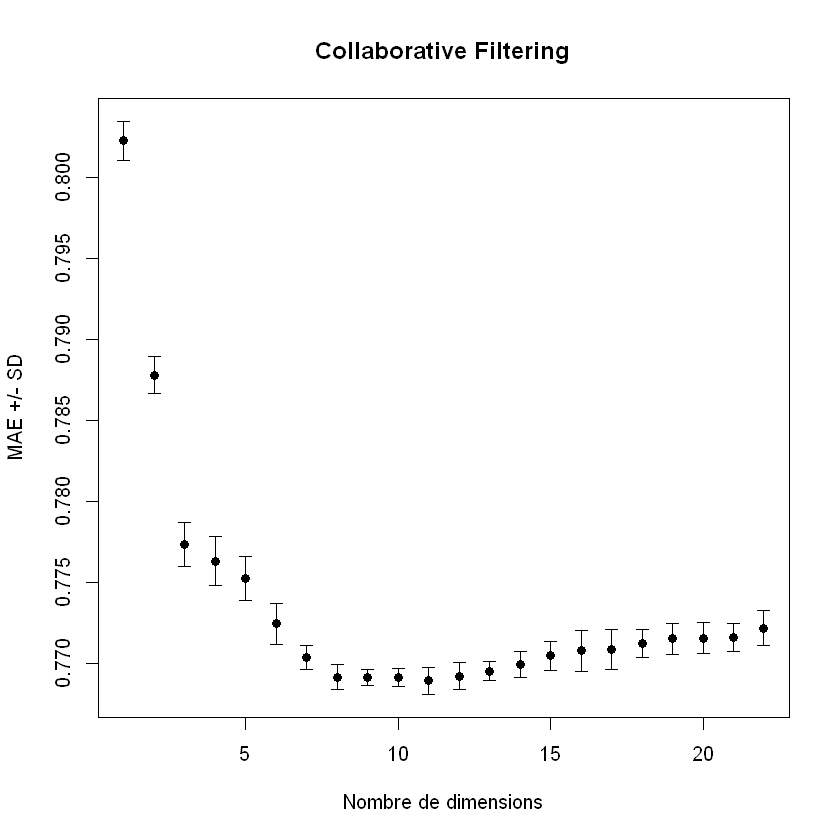

In [28]:
to.plot<-apply(to.plot,2,unlist)
sdev <- apply(to.plot,2,sd) 
avg <- colMeans(to.plot)
avg.cv <- mean(cv.b)
x <- 1:length(avg)
plot(x,colMeans(to.plot),ylim=range(avg-sdev, avg+sdev),pch=19, xlab="Nombre de dimensions", ylab="MAE +/- SD",
    main="Collaborative Filtering"
)
# hack: we draw arrows but with very special "arrowheads"
arrows(x, avg-sdev, x, avg+sdev, length=0.05, angle=90, code=3)

In [21]:
avg.cv

[1] 0.8120045

In [29]:
write.table(avg, file="out/total/CF.csv")